In [2]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)


from preprocess.graph import graph_topology_5
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from baselines.rcnn import rcnn_gate_generator_1
from models.graph_water_transformer_cov import graph_water_transformer_cov_gate_predictor

from losses.loss import gate_loss, water_level_threshold
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from postprocess.threshold import flood_threshold, drought_threshold, flood_threshold_t1, drought_threshold_t1
from spektral.layers import GCNConv

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [6]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


### Graph topology

In [7]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Model

#### Gate & pump predictor

In [8]:
# ===== model parameters ======
input_shape = train_X_mask.shape[1:]
rnn_unit = 64
cnn_unit = 32
dropout = 0.0
l1_reg = 0
l2_reg = 1e-5
kernel_size = 2
pool_size = 2
gate_min =0 
gate_max = 1

learning_rate = 1e-3
decay_steps = 10000
decay_rate = 0.9
PATIENCE = 100
EPOCHS = 700
BATCH = 512
input_shape = train_X_mask.shape[1:]

In [9]:
gate_predictor = rcnn_gate_generator_1(input_shape=input_shape,
                                       rnn_unit=rnn_unit,
                                       cnn_unit=cnn_unit,
                                       kernel_size=kernel_size,
                                       l1_reg=l1_reg, 
                                       l2_reg=l2_reg, 
                                       dropout=dropout,
                                       masked_value=masked_value,
                                       gate_min=gate_min,
                                       gate_max=gate_max
                                      )


gate_predictor._name = "gate_predictor"
gate_predictor.summary()

Model: "gate_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 16)]          0         
                                                                 
 masking (Masking)           (None, 96, 16)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 96, 64)            5184      
                                                                 
 dropout (Dropout)           (None, 96, 64)            0         
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            4128      
                                                                 
 max_pooling1d (MaxPooling1  (None, 24, 32)            0         
 D)                                                              
                                                    

2023-08-12 17:18:37.928050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


In [10]:
gate_predictor.compile(optimizer='adam', loss='mse')

#### water stage predictor

In [11]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

for layer in ws_predictor.layers:
    layer.trainable = False

ws_predictor._name = 'ws_predictor'    
# ws_predictor.summary()

#### Combine gate_predictor and trained ws_predictor

In [12]:
inputs_feat = Input(shape=(96, 16), name='inputs_feat')
inputs_tws = Input(shape=(5, 72), name='input_tws')
inputs_adj = Input(shape=(5, 5), name='input_adj')

# ================ gate_predictor ================
gate_predictor_output = gate_predictor(inputs_feat)  # 24*7


# ============  future inputs with replaced gate & pump prediction ============
replaced_future_gate_pump = layers.Concatenate(axis=-1)([inputs_feat[:, n_hours:, :2], 
                                                         gate_predictor_output, 
                                                         inputs_feat[:, n_hours:, 9:]
                                                        ]
                                                       )

# ============ original past inputs + future inputs with replaced gate & pump prediction ============
merged_inputs = layers.Concatenate(axis=1)([inputs_feat[:, :n_hours, :], replaced_future_gate_pump])
merged_inputs_cov = merged_inputs[:, :, :12]

ws_predictor_output = ws_predictor([merged_inputs_cov, inputs_tws, inputs_adj])

filda = Model(inputs=[inputs_feat, inputs_tws, inputs_adj], outputs=[gate_predictor_output, ws_predictor_output], name='filda')
# filda.summary()

Epoch 1/700

Epoch 1: val_ws_predictor_loss improved from inf to 2.60098, saving model to ../saved_models/rcnn_gtnp_1.h5
151/151 - 23s - loss: 0.5365 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2679 - val_loss: 5.2027 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.6010 - 23s/epoch - 153ms/step
Epoch 2/700


/aul/homes/jshi008/miniconda3/envs/tf213/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_ws_predictor_loss improved from 2.60098 to 2.06713, saving model to ../saved_models/rcnn_gtnp_1.h5
151/151 - 17s - loss: 0.5311 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2652 - val_loss: 4.1350 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.0671 - 17s/epoch - 112ms/step
Epoch 3/700

Epoch 3: val_ws_predictor_loss did not improve from 2.06713
151/151 - 16s - loss: 0.5198 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2595 - val_loss: 5.0252 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.5122 - 16s/epoch - 109ms/step
Epoch 4/700

Epoch 4: val_ws_predictor_loss did not improve from 2.06713
151/151 - 17s - loss: 0.5116 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.2554 - val_loss: 4.7659 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 2.3826 - 17s/epoch - 110ms/step
Epoch 5/700

Epoch 5: val_ws_predictor_loss did not improve from 2.06713
151/151 - 17s - loss: 0.5059 - gate_predictor_loss: 0

Epoch 30/700

Epoch 30: val_ws_predictor_loss did not improve from 1.65704
151/151 - 16s - loss: 0.3995 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1993 - val_loss: 3.4312 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7152 - 16s/epoch - 109ms/step
Epoch 31/700

Epoch 31: val_ws_predictor_loss did not improve from 1.65704
151/151 - 17s - loss: 0.3993 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1992 - val_loss: 3.3614 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6803 - 17s/epoch - 110ms/step
Epoch 32/700

Epoch 32: val_ws_predictor_loss did not improve from 1.65704
151/151 - 17s - loss: 0.3990 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1991 - val_loss: 3.4373 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.7182 - 17s/epoch - 109ms/step
Epoch 33/700

Epoch 33: val_ws_predictor_loss did not improve from 1.65704
151/151 - 16s - loss: 0.3987 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0

Epoch 59/700

Epoch 59: val_ws_predictor_loss did not improve from 1.57396
151/151 - 17s - loss: 0.3954 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1973 - val_loss: 3.2253 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6122 - 17s/epoch - 111ms/step
Epoch 60/700

Epoch 60: val_ws_predictor_loss did not improve from 1.57396
151/151 - 17s - loss: 0.3953 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1972 - val_loss: 3.1802 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5896 - 17s/epoch - 110ms/step
Epoch 61/700

Epoch 61: val_ws_predictor_loss did not improve from 1.57396
151/151 - 17s - loss: 0.3952 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1972 - val_loss: 3.2583 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.6287 - 17s/epoch - 111ms/step
Epoch 62/700

Epoch 62: val_ws_predictor_loss did not improve from 1.57396
151/151 - 17s - loss: 0.3956 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0

Epoch 88/700

Epoch 88: val_ws_predictor_loss did not improve from 1.55180
151/151 - 17s - loss: 0.3943 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1967 - val_loss: 3.1730 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5860 - 17s/epoch - 112ms/step
Epoch 89/700

Epoch 89: val_ws_predictor_loss did not improve from 1.55180
151/151 - 17s - loss: 0.3939 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1965 - val_loss: 3.1615 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5803 - 17s/epoch - 112ms/step
Epoch 90/700

Epoch 90: val_ws_predictor_loss did not improve from 1.55180
151/151 - 17s - loss: 0.3939 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1965 - val_loss: 3.1925 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5958 - 17s/epoch - 111ms/step
Epoch 91/700

Epoch 91: val_ws_predictor_loss did not improve from 1.55180
151/151 - 17s - loss: 0.3942 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0

Epoch 117/700

Epoch 117: val_ws_predictor_loss improved from 1.54991 to 1.54894, saving model to ../saved_models/rcnn_gtnp_1.h5
151/151 - 17s - loss: 0.3931 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1961 - val_loss: 3.0988 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5489 - 17s/epoch - 111ms/step
Epoch 118/700

Epoch 118: val_ws_predictor_loss did not improve from 1.54894
151/151 - 17s - loss: 0.3930 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1960 - val_loss: 3.1263 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5627 - 17s/epoch - 112ms/step
Epoch 119/700

Epoch 119: val_ws_predictor_loss did not improve from 1.54894
151/151 - 17s - loss: 0.3929 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1960 - val_loss: 3.1433 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5712 - 17s/epoch - 112ms/step
Epoch 120/700

Epoch 120: val_ws_predictor_loss did not improve from 1.54894
151/151 - 17s - loss: 0.3

Epoch 146/700

Epoch 146: val_ws_predictor_loss did not improve from 1.54894
151/151 - 17s - loss: 0.3925 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1958 - val_loss: 3.1591 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5791 - 17s/epoch - 115ms/step
Epoch 147/700

Epoch 147: val_ws_predictor_loss did not improve from 1.54894
151/151 - 17s - loss: 0.3924 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1957 - val_loss: 3.1931 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5961 - 17s/epoch - 110ms/step
Epoch 148/700

Epoch 148: val_ws_predictor_loss did not improve from 1.54894
151/151 - 16s - loss: 0.3921 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1956 - val_loss: 3.1979 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5985 - 16s/epoch - 108ms/step
Epoch 149/700

Epoch 149: val_ws_predictor_loss did not improve from 1.54894
151/151 - 17s - loss: 0.3930 - gate_predictor_loss: 0.0000e+00 - ws_predictor

151/151 - 17s - loss: 0.3919 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1955 - val_loss: 3.1873 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5932 - 17s/epoch - 110ms/step
Epoch 176/700

Epoch 176: val_ws_predictor_loss did not improve from 1.54894
151/151 - 16s - loss: 0.3918 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1954 - val_loss: 3.1834 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5913 - 16s/epoch - 108ms/step
Epoch 177/700

Epoch 177: val_ws_predictor_loss did not improve from 1.54894
151/151 - 17s - loss: 0.3916 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1953 - val_loss: 3.1686 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5838 - 17s/epoch - 112ms/step
Epoch 178/700

Epoch 178: val_ws_predictor_loss did not improve from 1.54894
151/151 - 17s - loss: 0.3919 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1955 - val_loss: 3.1510 - val_gate_predictor_loss: 0.0000e+00 - val_

Epoch 205/700

Epoch 205: val_ws_predictor_loss did not improve from 1.54894
151/151 - 17s - loss: 0.3917 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1954 - val_loss: 3.1718 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5854 - 17s/epoch - 113ms/step
Epoch 206/700

Epoch 206: val_ws_predictor_loss did not improve from 1.54894
151/151 - 17s - loss: 0.3919 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1955 - val_loss: 3.1506 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5748 - 17s/epoch - 112ms/step
Epoch 207/700

Epoch 207: val_ws_predictor_loss did not improve from 1.54894
151/151 - 17s - loss: 0.3914 - gate_predictor_loss: 0.0000e+00 - ws_predictor_loss: 0.1952 - val_loss: 3.1277 - val_gate_predictor_loss: 0.0000e+00 - val_ws_predictor_loss: 1.5634 - 17s/epoch - 114ms/step
Epoch 208/700

Epoch 208: val_ws_predictor_loss did not improve from 1.54894
151/151 - 17s - loss: 0.3913 - gate_predictor_loss: 0.0000e+00 - ws_predictor

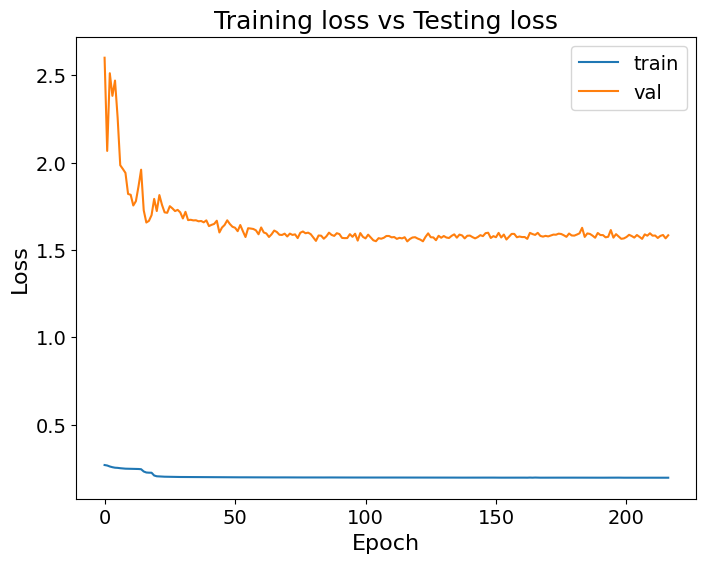

In [26]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
                                                          decay_steps=decay_steps,
                                                          decay_rate=decay_rate)

filda.compile(optimizer=Adam(learning_rate=lr_schedule),
             loss=[gate_loss, water_level_threshold], 
             loss_weights=[0.0, 2.0]
            )


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
mc = ModelCheckpoint('../saved_models/rcnn_gtnp_1.h5'.format(n_hours, K),
                     monitor='val_ws_predictor_loss',
                     mode='min',
                     verbose=2, 
                     custom_objects={'gate_loss':gate_loss, 'water_level_threshold':water_level_threshold}, 
                     save_best_only=True)


history = filda.fit([train_X_mask, train_tws_reshape, train_adj_mat], [train_gate_pump_y, train_ws_y],
                   validation_data=([val_X_mask, val_tws_reshape, val_adj_mat], [val_gate_pump_y, val_ws_y]),
                   batch_size=BATCH, 
                   epochs=EPOCHS, 
                   verbose=2, 
                   callbacks=[es, mc],
                   shuffle=True,

                  )


plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['ws_predictor_loss'], label='train')
plt.plot(history.history['val_ws_predictor_loss'], label='val')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [13]:
saved_model = load_model('../saved_models/rcnn_gtnp_1.h5',
                         custom_objects={'gate_loss':gate_loss, 
                                         'water_level_threshold':water_level_threshold,
                                         'GCNConv': GCNConv
                                        }
                        )

In [14]:
start_time = time.perf_counter()


gate_pump_pred, ws_pred = saved_model.predict([test_X_mask, test_tws_reshape, test_adj_mat])

print(gate_pump_pred.shape)
print(ws_pred.shape)



end_time = time.perf_counter()
used_time = end_time - start_time
print(f"Usded time: {used_time} seconds")

2023-08-12 17:18:54.589852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


603/603 [==============================] - 12s 17ms/step
(19268, 24, 7)
(19268, 96)
Usded time: 13.271579616703093 seconds


#### ws pred, gate pred

In [14]:
ws_pred_gate_pred_inv = ws_scaler.inverse_transform(ws_pred)
ws_pred_gate_pred_inv = ws_pred_gate_pred_inv.reshape((-1, K, 4))
ws_pred_gate_pred_inv.shape

(19268, 24, 4)

#### ws true, gate true

In [15]:
ws_true_gate_true = test_ws_y
ws_true_gate_true_inv = ws_scaler.inverse_transform(ws_true_gate_true)
ws_true_gate_true_inv = ws_true_gate_true_inv.reshape((-1, K, 4))
ws_true_gate_true_inv.shape

(19268, 24, 4)

#### ws pred, gate true

In [16]:
ws_predictor = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

ws_pred_gate_true = ws_predictor.predict([test_cov, test_tws_reshape, test_adj_mat])
ws_pred_gate_true_inv = ws_scaler.inverse_transform(ws_pred_gate_true)
ws_pred_gate_true_inv = ws_pred_gate_true_inv.reshape((-1, 24, 4))
ws_pred_gate_true_inv.shape

603/603 [==============================] - 2s 3ms/step


(19268, 24, 4)

### Upper threshould

In [17]:
upper_threshold = 3.5
t1 = 1

flood_threshold_t1(ws_true_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv, t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv, t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 96, 96, 118, 117
S1, S25A, S25B, S26 areas: 14.82, 15.22, 18, 20.13
TOTAL time steps: 427; TOTAL areas: 68.61
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 85, 85, 96, 108
S1, S25A, S25B, S26 areas: 11.5466, 12.1773, 13, 17.2181
TOTAL time steps: 374; TOTAL areas: 54.3063
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 29, 38, 38, 65
S1, S25A, S25B, S26 areas: 3.287, 4.6664, 4, 7.8841
TOTAL time steps: 170; TOTAL areas: 20.0126
--------------------------------------------------


In [23]:
flood_threshold_t1(ws_true_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_true_inv[7640-23:7680-23], t1, upper_threshold)
flood_threshold_t1(ws_pred_gate_pred_inv[7640-23:7680-23], t1, upper_threshold)

S1, S25A, S25B, S26 time steps: 6, 5, 6, 6
S1, S25A, S25B, S26 areas: 0.84, 0.72, 1, 1.0
TOTAL time steps: 23; TOTAL areas: 3.62
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 6, 6, 5, 5
S1, S25A, S25B, S26 areas: 0.6148, 0.6425, 1, 0.8663
TOTAL time steps: 22; TOTAL areas: 3.0018
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 1, 1, 2, 2
S1, S25A, S25B, S26 areas: 0.0455, 0.1061, 0, 0.1426
TOTAL time steps: 6; TOTAL areas: 0.3906
--------------------------------------------------


In [18]:
flood_threshold(ws_true_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_true_inv, upper_threshold)
flood_threshold(ws_pred_gate_pred_inv, upper_threshold)

time steps: 10248, areas: 1646.6399002075195
time steps: 12130, areas: 2088.0380942821503
time steps: 9301, areas: 1537.7514479160309


### Lower threshold

In [20]:
lower_threshold = 0
t1 = 1

drought_threshold_t1(ws_true_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_true_inv, t1, lower_threshold)
drought_threshold_t1(ws_pred_gate_pred_inv, t1, lower_threshold)

S1, S25A, S25B, S26 time steps: 1346, 1341, 1229, 1250
S1, S25A, S25B, S26 areas: -385.8, -383.38, -345.08, -350.84:
TOTAL time steps: 5166; TOTAL areas: -1465.1
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 1390, 1427, 1282, 1476
S1, S25A, S25B, S26 areas: -398.849, -392.0414, -350.2885, -429.5386:
TOTAL time steps: 5575; TOTAL areas: -1570.7176
--------------------------------------------------
S1, S25A, S25B, S26 time steps: 328, 36, 41, 137
S1, S25A, S25B, S26 areas: -58.6874, -4.8633, -3.8639, -21.3137:
TOTAL time steps: 542; TOTAL areas: -88.7282
--------------------------------------------------


In [21]:
lower_threshold = 0

drought_threshold(ws_true_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_true_inv, lower_threshold)
drought_threshold(ws_pred_gate_pred_inv, lower_threshold)

time steps: 124148, areas: 35182.6098122485
time steps: 127126, areas: 34960.07284716559
time steps: 12274, areas: 1993.745101514336


In [22]:
ws_true_gate_true_inv_24 = ws_true_gate_true_inv[:, -1, :]
ws_pred_gate_true_inv_24 = ws_pred_gate_true_inv[:, -1, :]
ws_pred_gate_pred_inv_24 = ws_pred_gate_pred_inv[:, -1, :]

ws_true_gate_true_inv_24 = ws_true_gate_true_inv_24.reshape((-1, 1, 4))
ws_pred_gate_true_inv_24 = ws_pred_gate_true_inv_24.reshape((-1, 1, 4))
ws_pred_gate_pred_inv_24 = ws_pred_gate_pred_inv_24.reshape((-1, 1, 4))

drought_threshold(ws_true_gate_true_inv_24, lower_threshold)
drought_threshold(ws_pred_gate_true_inv_24, lower_threshold)
drought_threshold(ws_pred_gate_pred_inv_24, lower_threshold)

time steps: 5174, areas: 1466.089992186986
time steps: 4948, areas: 1318.0994580857077
time steps: 333, areas: 52.20509308481269


### Attention visaulization

In [23]:
gate_pump_pred, ws_pred = saved_model.predict(test_X_mask)

print(gate_pump_pred.shape)

print(ws_pred.shape)

(19268, 24, 7)
(19268, 96)


In [24]:
gate_pump_pred_reshape = gate_pump_pred.reshape((-1, 24*7))
gate_pump_pred_inv = gate_pump_scaler.inverse_transform(gate_pump_pred_reshape)
gate_pump_pred_inv = gate_pump_pred_inv.reshape((-1, 24, 7))
print(gate_pump_pred_inv.shape)

(19268, 24, 7)


In [25]:
# prediction
gate_pump_pred_demo = gate_pump_pred[demo]
gate_pump_pred_demo = gate_pump_pred_demo.reshape((24*7, 1))


# original data
original_input_demo = test_X_mask[demo]
original_input_demo = original_input_demo.reshape((1, 96*16))
original_input_demo = scaler.inverse_transform(original_input_demo)
original_input_demo = original_input_demo.reshape((96, 16))

print(gate_pump_pred_demo.shape, original_input_demo.shape)

NameError: name 'demo' is not defined

In [ ]:
VARS = ['MEAN_RAIN', 'WS_S4',
        'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
        'PUMP_S25B', 'PUMP_S26',
        #'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 
        'HWS_S25A', 'HWS_S25B', 'HWS_S26',
        'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

FONTSIZE = 14

for i in range(len(VARS)):
    print("Attention for {} input:".format(VARS[i]))
    atte_opt, atte_score = layers.Attention()([gate_pump_pred_demo, original_input_demo[:, i:i+1]], 
                                              return_attention_scores=True
                                             )
    plt.rcParams["figure.figsize"] = (16, 13)

    ax = sns.heatmap(atte_score, cmap="viridis")   # , cmap="crest"
    ax.xaxis.tick_top()
    plt.ylabel("Output: Gate & Pump (hrs)", fontsize=FONTSIZE)
#     plt.xlabel("Input: {} (hrs)".format(VARS[i]), fontsize=FONTSIZE)
    plt.title("Input: {} (hrs)".format(VARS[i]), fontsize=FONTSIZE)
    #plt.title("Attention Score: Output (24*4 hrs) vs Input {} (96 hrs)".format(VARS[i]), fontsize=FONTSIZE)
    plt.show()

In [ ]:
gate_pump = ['GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S25B', 'PUMP_S26']

for i in range(len(gate_pump)):
    plt.rcParams["figure.figsize"] = (9, 1.5)
    plt.plot(gate_pump_pred_inv[demo, :, i])
    plt.xlabel('Time steps')
    plt.ylabel('{}'.format(gate_pump[i]))
    plt.show()
#     plt.close()

In [ ]:
INPUTS = ['MEAN_RAIN', 'WS_S4',
          'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
          'PUMP_S25B', 'PUMP_S26',
          #'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 
          'HWS_S25A', 'HWS_S25B', 'HWS_S26',
          'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']


test_X_mask_reshape = test_X_mask.reshape((-1, 96*16))
print(test_X_mask_reshape.shape)

test_X_mask_inv = scaler.inverse_transform(test_X_mask_reshape)
print(test_X_mask_inv.shape)

test_X_mask_inv = test_X_mask_inv.reshape((-1, 96, 16))
print(test_X_mask_inv.shape)


plt.rcParams["figure.figsize"] = (9, 25)
fig = plt.figure(tight_layout=True)
gs = matplotlib.gridspec.GridSpec(len(INPUTS), 1)


for i in range(len(INPUTS)):
    ax = fig.add_subplot(gs[i, :])
    ax.plot(test_X_mask_inv[demo, :, i], linewidth=1.5)
    ax.set_title('{}'.format(INPUTS[i]), fontsize=12)
    plt.xticks(np.arange(0, 96, 4))
    
    
#     plt.rcParams["figure.figsize"] = (9, 1.5)
#     plt.plot(test_X_mask_inv[demo, :, i])
#     plt.xlabel('Time steps')
#     plt.ylabel('{}'.format(INPUTS[i]))
#     plt.show()
#     plt.close()

# plt.align_labels()
# plt.savefig('INPUTS.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from explainability import integrated_gradients, colorline

In [ ]:
input_data = test_X_mask[demo:demo+1]
baseline_data = np.zeros((1, 96, 19), dtype=np.float32)

# Compute integrated gradients
attributions = integrated_gradients(gate_predictor, input_data, baseline_data)


feature_matrix = []
attribute_matrix = []

for feature, attribution in zip(input_data[0], attributions[0]):
    #print(feature.shape, input_data[0].shape)
    #print(f"Feature: {feature}, Attribution: {attribution}")
    feature_matrix.append(feature)
    attribute_matrix.append(attribution.numpy()) 

In [ ]:
feature_matrix_np = np.array(feature_matrix)
attribute_matrix_np = np.array(attribute_matrix)

In [ ]:
# paper: https://arxiv.org/pdf/1703.01365.pdf

"""
The Integrated Gradients method computes the integral of gradients along a straight path 
between a baseline input and the actual input to attribute importance to each feature. 

The key idea behind is to assign attribution or importance scores to the input features of a deep neural network, 
indicating their contribution to the network's output predictions.
"""

# Create a heatmap
plt.rcParams["figure.figsize"] = (19, 6)
sns.heatmap(attribute_matrix_np.T, cmap='viridis')

# Add labels and title
plt.ylabel("Features")
plt.xlabel("Time steps")
plt.title("Importance scores to input features")

# Display the plot
plt.show()

In [ ]:
labels = ['MEAN_RAIN', 'WS_S4',
          'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
          'PUMP_S25B', 'PUMP_S26',
          #'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 
          'HWS_S25A', 'HWS_S25B', 'HWS_S26',
          'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

df_cm = pd.DataFrame(attribute_matrix_np, columns = labels)
plt.rcParams["figure.figsize"] = (19, 6)
sns.heatmap(df_cm.T, annot=False, cmap='viridis')

In [ ]:
labels = ['MEAN_RAIN', 'WS_S4',
          'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
          'PUMP_S25B', 'PUMP_S26',
          #'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 
          'HWS_S25A', 'HWS_S25B', 'HWS_S26',
          'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']

for i in range(len(labels)):
    plt.figure(figsize = (9, 1))
    plt.plot(df_cm[labels[i]])
    plt.ylabel('{}'.format(labels[i]))
    plt.show()
    plt.close()

In [ ]:
# from matplotlib.collections import LineCollection


# def colorline(x, y, z=None, cmap=plt.get_cmap('viridis'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
#     '''
#     Plot a colored line with coordinates x and y
#     Optionally specify colors in the array z
#     Optionally specify a colormap, a norm function and a line width
#     '''
#     if z is None:
#         z = np.linspace(0.0, 1.0, len(x))

#     segments = np.array([x, y]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([segments[:-1], segments[1:]], axis=1)

#     lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
#     plt.gca().add_collection(lc)

#     return lc

# Topics: line, color, LineCollection, cmap, colorline, codex
'''
Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
The color is taken from optional data in z, and creates a LineCollection.

z can be:
- empty, in which case a default coloring will be used based on the position along the input arrays
- a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
- an array of the length of at least the same length as x, to color according to this data
- an array of a smaller length, in which case the colors are repeated along the curve

The function colorline returns the LineCollection created, which can be modified afterwards.

See also: plt.streamplot
'''

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 

In [ ]:
INPUTS = ['MEAN_RAIN', 'WS_S4',
          'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
          'PUMP_S25B', 'PUMP_S26',
          'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 
          'HWS_S25A', 'HWS_S25B', 'HWS_S26',
          'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']


test_X_mask_reshape = test_X_mask.reshape((-1, 96*19))
print(test_X_mask_reshape.shape)

test_X_mask_inv = scaler.inverse_transform(test_X_mask_reshape)
print(test_X_mask_inv.shape)

test_X_mask_inv = test_X_mask_inv.reshape((-1, 96, 19))
print(test_X_mask_inv.shape)


plt.rcParams["figure.figsize"] = (14, 27)
fig = plt.figure(tight_layout=True)
gs = matplotlib.gridspec.GridSpec(len(INPUTS), 1)


for i in range(len(INPUTS)):
    ax = fig.add_subplot(gs[i, :])
    ax.plot(test_X_mask_inv[demo, :, i], linewidth=1.5)   # demo
    
    # Example usage
    background = np.linspace(0, 95, 96)
    series = test_X_mask_inv[demo, :, i]
    series_score = df_cm[INPUTS[i]]
    series_score = (series_score - np.min(series_score)) / (np.max(series_score) - np.min(series_score))
#     colorline(background, series, series_score)

    # Create a scatter plot with a color gradient to represent the line
    scatter = ax.scatter(background, series, c=series_score, 
    #                      cmap=plt.cm.jet,
                         cmap='viridis', 
                         s=30)  # viridis copper

    # Add a colorbar on the right side
    cbar = fig.colorbar(scatter, 
                        ax=ax, 
                        label='Importance', 
                        aspect=10, 
                        pad=0.02)
    
    ax.set_ylabel('{}'.format(INPUTS[i]), fontsize=10)
    plt.xticks(np.arange(0, 96, 4))
    

# plt.align_labels()
# plt.savefig('INPUTS.png', dpi=300, bbox_inches='tight')
plt.show()